In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from casadi import *
import numpy as np
import dpilqr
import matplotlib.pyplot as plt
import util
from time import perf_counter

### Regular centralized MPC, no consensus

In [3]:
def linear_kinodynamics(dt,n_agent):
    #Decision vector is a = [a_x, a_y, a_z]
    #State vector is X = [p_x, p_y, p_z, v_x, v_y, v_z]
    #Discretization time step is dt
    A_tot = np.zeros((6*n_agent, 6*n_agent))
    B_tot = np.zeros((6*n_agent, 3*n_agent))
    A = np.array([[1, 0, 0, dt, 0, 0],
                           [0, 1, 0, 0 , dt ,0],\
                           [0, 0, 1, 0, 0 , dt],\
                           [0, 0, 0, 1, 0 ,0],\
                           [0, 0, 0, 0, 1 ,0],\
                           [0, 0, 0, 0, 0, 1]])
    B = np.array([[dt**2/2, 0, 0],\
                           [0, dt**2/2, 0],\
                           [0, 0, dt**2/2],\
                           [dt, 0, 0 ],\
                           [0, dt , 0],\
                           [0, 0, dt]])

    for i in range(n_agent):
        A_tot[i*6:(i+1)*6,i*6:(i+1)*6] = A
        B_tot[i*6:(i+1)*6,i*3:(i+1)*3] = B
        
    
    return A_tot, B_tot

In [4]:
"""Define constants"""
n_inputs = 3
n_agents = 2
nx = 6 * n_agents
nu = 3 * n_agents
x0,xr = util.paper_setup_2_quads(False)
# x0 = np.array([1.5, 1.2, 1, 0, 0, 0]).reshape(-1,1)
# xr = np.array([-1.5,-1.5, 1.2, 0, 0, 0]).reshape(-1,1)
N = n_agents
T = 8
Q = np.diag([5., 5., 5., 1., 1., 1.]*N)
Qf = Q*500
R = 0.1*np.eye(N*n_inputs)
radius = 0.5
Ad, Bd = linear_kinodynamics(0.1, N)

In [ ]:
opti = Opti()
Y_state = opti.variable((T+1)*nx + T*nu)
cost = 0
for t in range(T):
    for idx in range(nx):
        cost += (Y_state[:(T+1)*nx][t*nx:(t+1)*nx][idx]-xr[idx]) *  \
        Q[idx,idx]* (Y_state[:(T+1)*nx][t*nx:(t+1)*nx][idx]-xr[idx]) 
    for idu in range(nu):
        cost += (Y_state[(T+1)*nx:][t*nu:(t+1)*nu][idu]) *  \
        R[idu,idu] * (Y_state[(T+1)*nx:][t*nu:(t+1)*nu][idu])

for idf in range(nx):
    cost += (Y_state[:(T+1)*nx][T*nx:(T+1)*nx][idf] - xr[idf]) * \
    Qf[idf,idf] * (Y_state[:(T+1)*nx][T*nx:(T+1)*nx][idf] - xr[idf])

In [ ]:
coll_cost = 0
smooth_trj_cost = 0
solution_trj = []
obj_hist = []
x_curr = x0

X_trj = np.zeros((0, nx))
U_trj = np.zeros((0, nu))
X_trj = np.r_[X_trj, x0.T]
iters = 0

solve_times = []
x_dims = [6]*N
n_dims = [3]*N
while not np.all(dpilqr.distance_to_goal(x_curr.flatten(), xr.flatten(), n_agents, 6, 3) <= 0.1):

    for k in range(T):
        
        opti.subject_to(Y_state[:(T+1)*nx][(k+1)*nx:(k+2)*nx] \
                        == Ad @ Y_state[:(T+1)*nx][k*nx:(k+1)*nx] \
                            + Bd @ Y_state[(T+1)*nx:][k*nu:(k+1)*nu])

        opti.subject_to(Y_state[(T+1)*nx:][k*nu:(k+1)*nu] <= np.tile(np.array([3, 3, 3]),(N,)).reshape(-1,1))
        opti.subject_to(np.tile(np.array([-3, -3, -3]),(N,)).reshape(-1,1) <= Y_state[(T+1)*nx:][k*nu:(k+1)*nu])

        #Pair-wise Euclidean distance between each pair of agents
        if N > 1:

            distances = util.compute_pairwise_distance_nd_Sym(Y_state[:(T+1)*nx][k*nx:(k+1)*nx],x_dims, n_dims)
            #Collision avoidance cost
            for dist in distances:
                coll_cost += fmin(0,(dist - radius))**2 * 400
                # coll_cost += fmin(0,(dist - radius))**2 * 1200
                # opti.subject_to(dist >= radius)
   
        #Smoothing term
        for ind in range(nx):
            smooth_trj_cost += (Y_state[:(T+1)*nx][(k+1)*nx:(k+2)*nx][ind]-\
                                Y_state[:(T+1)*nx][k*nx:(k+1)*nx][ind])**2

    X0 = opti.parameter(x0.shape[0],1)    
    # opti.subject_to(Y_state[0:nx] == x_curr) 
    opti.subject_to(Y_state[0:nx] == X0)
    
    cost_tot = cost + coll_cost + smooth_trj_cost
    opti.minimize(cost_tot)

    opti.solver("ipopt")
    opti.set_value(X0,x_curr)
    
    if iters > 0:
        opti.set_initial(sol_prev.value_variables())
        
    t0 = perf_counter()
    sol = opti.solve()
    solve_times.append(perf_counter() - t0)
    sol_prev = sol
    
    obj_hist.append(sol.value(cost_tot))
    
    ctrl = sol.value(Y_state)[(T+1)*nx:].reshape((T, nu))[0]
    # x_curr = Ad@x_curr + (Bd @ ctrl).reshape(-1,1) #Apply first element in the control sequence
    x_curr = sol.value(Y_state)[:(T+1)*nx].reshape((T+1,nx))[1]
    X_trj = np.r_[X_trj, x_curr.reshape(1,-1)]
    U_trj = np.r_[U_trj, ctrl.reshape(1,-1)]
    
    opti.subject_to()
    
    iters += 1
    

Function solver_qpsol (0x7fffd2f01000)
Input 0 (h): sparse: 156-by-156, 588 nnz
 (0, 0) -> -11837.1
 (1, 0) -> 0
 (2, 0) -> 0
 (6, 0) -> 11849.1
 (7, 0) -> 0
 (8, 0) -> 0
 (12, 0) -> -2
 (0, 1) -> 0
 (1, 1) -> -11837.1
 (2, 1) -> 0
 (6, 1) -> 0
 (7, 1) -> 11849.1
 (8, 1) -> 0
 (13, 1) -> -2
 (0, 2) -> 0
 (1, 2) -> 0
 (2, 2) -> -11837.1
 (6, 2) -> 0
 (7, 2) -> 0
 (8, 2) -> 11849.1
 (14, 2) -> -2
 (3, 3) -> 4
 (15, 3) -> -2
 (4, 4) -> 4
 (16, 4) -> -2
 (5, 5) -> 4
 (17, 5) -> -2
 (0, 6) -> 11849.1
 (1, 6) -> 0
 (2, 6) -> 0
 (6, 6) -> -11837.1
 (7, 6) -> 0
 (8, 6) -> 0
 (18, 6) -> -2
 (0, 7) -> 0
 (1, 7) -> 11849.1
 (2, 7) -> 0
 (6, 7) -> 0
 (7, 7) -> -11837.1
 (8, 7) -> 0
 (19, 7) -> -2
 (0, 8) -> 0
 (1, 8) -> 0
 (2, 8) -> 11849.1
 (6, 8) -> 0
 (7, 8) -> 0
 (8, 8) -> -11837.1
 (20, 8) -> -2
 (9, 9) -> 4
 (21, 9) -> -2
 (10, 10) -> 4
 (22, 10) -> -2
 (11, 11) -> 4
 (23, 11) -> -2
 (0, 12) -> -2
 (12, 12) -> -11835.1
 (13, 12) -> 0
 (14, 12) -> 0
 (18, 12) -> 11849.1
 (19, 12) -> 0
 (20, 1

-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 156, constraints m = 360
          nnz(P) + nnz(A) = 2460
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: off, polish: off, 
-----------------------------------------------------------------
           OSQP v0.6.2  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
----------

0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input 8 (lam_x0): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Input 9 (lam_a0): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

RuntimeError: Error in Opti::solve [OptiNode] at .../casadi/core/optistack.cpp:157:
Error in Function::call for 'solver' [MXFunction] at .../casadi/core/function.cpp:1401:
Error in Function::call for 'solver' [MXFunction] at .../casadi/core/function.cpp:330:
Error in Function::operator() for 'solver_qpsol' [OsqpInterface] at .../casadi/core/function.cpp:1482:
.../casadi/core/conic.cpp:537: conic process failed. Set 'error_on_fail' option to false to ignore this error.

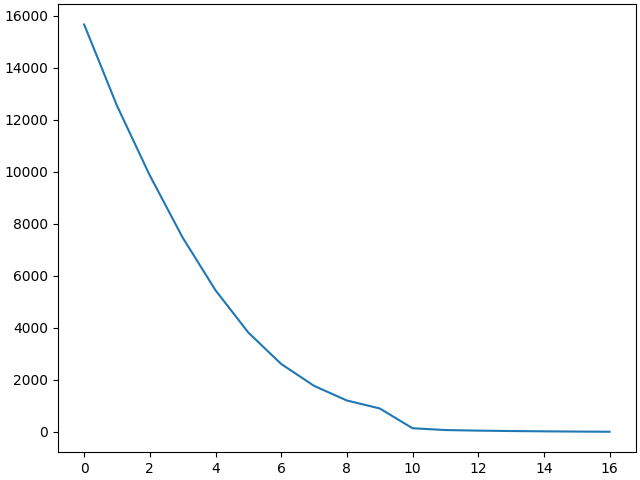

In [131]:
plt.figure()
plt.plot(obj_hist)

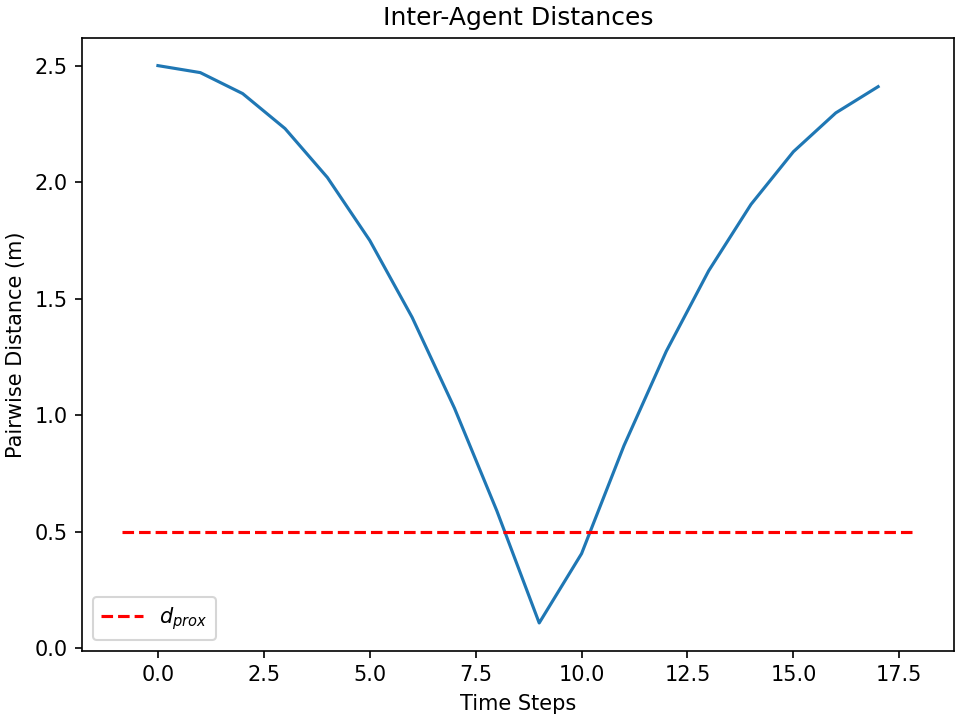

In [132]:
plt.figure(dpi=150)
dpilqr.plot_pairwise_distances(X_trj,x_dims,n_dims,radius)

In [133]:
u_ref = np.array([0, 0, 0]*n_agents)

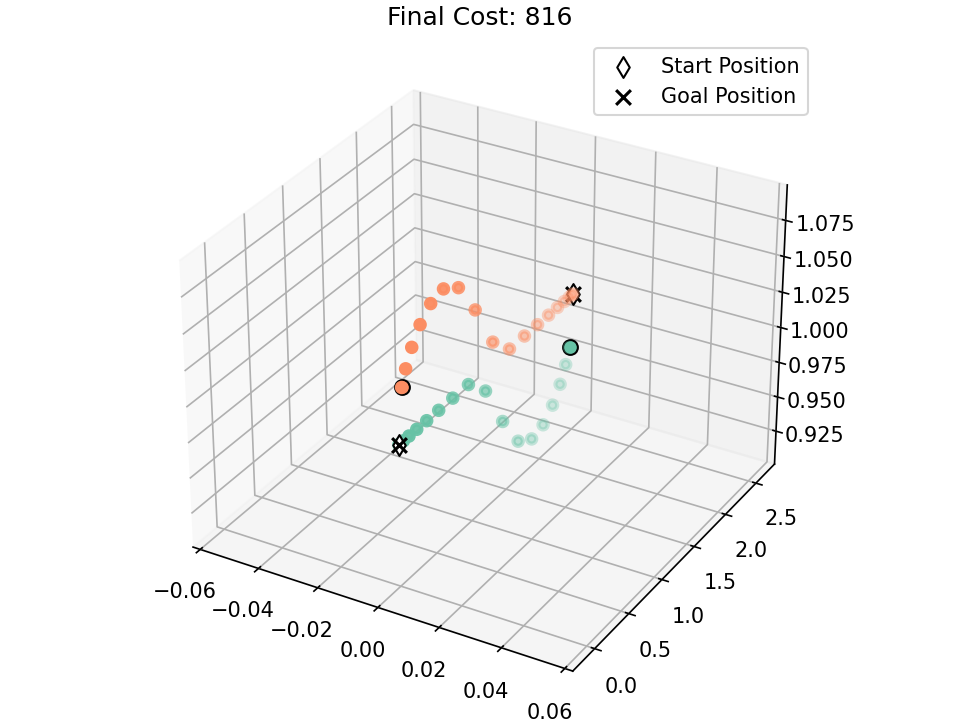

In [134]:
%matplotlib ipympl
plt.figure(dpi=150);
dpilqr.plot_solve(X_trj, float(util.objective(X_trj.T, U_trj.T, u_ref, xr, Q, R, Qf)), xr, x_dims, True, n_d=3);
plt.legend(plt.gca().get_children()[1:3], ["Start Position", "Goal Position"])
# plt.savefig('Casadi_MPC_demo.png')

In [135]:
dpilqr.distance_to_goal(X_trj[-1].reshape(-1,1),xr, N, 6, 3)

array([0.059, 0.059])

In [136]:
np.mean(solve_times)

0.37244123941170126

In [137]:
np.std(solve_times)

0.2617369231052874

In [138]:
U_trj.shape

(17, 6)

In [139]:
X_trj.shape

(18, 12)